Load `torch`. Note the version on colab can lag behind the most current release. If you need something new you can install using e.g. !pip3 install torch==1.4.0

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pickle

import biophysnn

from importlib import reload
reload(biophysnn)

<module 'biophysnn' from '/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/biophysnn.py'>

## Loading data

To test this out we need some data! Our first task will be predict binding of the important transcriptional repressor CTCF in a human lung cancer cell line called A549. The data is available from ENCODE including merging replicate experiments using the "irreproducible discovery rate" (IDR) [paper](https://arxiv.org/abs/1110.4705) [code](https://github.com/spundhir/idr). Genomics data representing discrete binding events is typically stored in the  `bed` format, which is described on the UCSC Genome Browser [website](https://genome.ucsc.edu/FAQ/FAQformat.html#format1). This bed file has some additional columns we will ignore. 

In [4]:
import pandas as pd
binding_data = pd.read_csv("/gpfs/commons/home/daknowles/RIPnet/all_hnrnpk_rep1_stranded.narrowPeak.gz", sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data[:10]

,chrom,start,end,name,score,strand
0,chr1,16099,16580,all_hnrnpk_rep1_neg_peak_35,81,-
1,chr1,19237,19896,all_hnrnpk_rep1_neg_peak_36,48,-
2,chr1,136471,137136,all_hnrnpk_rep1_neg_peak_37,73,-
3,chr1,186383,187169,all_hnrnpk_rep1_neg_peak_38,54,-
4,chr1,190825,191102,all_hnrnpk_rep1_neg_peak_39,51,-
5,chr1,191639,191980,all_hnrnpk_rep1_neg_peak_40,21,-
6,chr1,505655,505859,all_hnrnpk_rep1_neg_peak_41,37,-
7,chr1,516297,516694,all_hnrnpk_rep1_neg_peak_42,31,-
8,chr1,528944,529147,all_hnrnpk_rep1_neg_peak_43,118,-
9,chr1,529788,529988,all_hnrnpk_rep1_neg_peak_44,82,-


`chrom` is the chromosome (we filter out the sex chromosomes X and Y to avoid bias from these being haploid, you could try keeping them though). `start` and `end` are positions in the genome. `name` and `strand` aren't used here. Some genomics assays (e.g. RNA-seq) correspond to one strand of the DNA or the other. However, for our purposes at least we can consider ChIP-seq and ATAC-seq as "unstranded", which is why that column is all "." rather than + or -.  `score` is a quantitative measure of binding. We'll ignore this for now (since all these peaks are statistically significant), but you could try to incorporate it in your model training if you want (e.g. multitask for binary binding plus predicting `score`). 

We'll split the binding data into training, validation (chroms 2 and 3, ~) and test (chrom 1), which represents about 14% of the training data we have: 

In [5]:
test_chromosomes = ["chr1"]
test_data = binding_data[ binding_data['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = binding_data[ binding_data['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = binding_data[ binding_data['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / binding_data.shape[0], validation_data.shape[0] / binding_data.shape[0]

(0.0974892558244741, 0.14894477459507996)

We'll also need the human genome, which we provide here as a pickle since it's faster to load compared to reading in a text file. 

It's worth knowing that the human genome has different *versions* that are released as more missing parts are resolved by continued sequencing and assembly efforts. Version `GRCh37` (also called `hg19`) was released in 2009, and `GRCh38` (`hg38`) was released in 2013. We'll be using `hg19` here but `GRCh38` is finally becoming more standard so always check your data is what you think it is. 

This will take a minute or two. 

In [6]:

genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

`genome` is just a dictionary where the keys are the chromosome names and the values are strings representing the actual DNA. Ns represents "missing" regions, typically because the region has too many repetitive sequences making mapping impossible, which is especially the case in [centrosomes](https://en.wikipedia.org/wiki/Centrosome) and [telomeres](https://en.wikipedia.org/wiki/Telomere). Resolving these difficult to map regions is an ongoing effort. 

## Load known PWMs

In [7]:
pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
pwm_names = pwm_dat['names']
pwms = pwm_dat['pwms']

pwms[pwms > 0].min()
log_pwms = np.log(pwms + 1e-4)

# Convert to actual PWM
w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
w_norm = w - w.mean(1,keepdims=True)

w_norm.shape

torch.Size([453, 4, 7])

In [8]:
specific_pwms = w_norm[ np.array([ "HNRNPK" in g for g in pwm_names ]) ]
specific_pwms.shape

torch.Size([5, 4, 7])

## Test phys net

In [54]:
# results = []
import os.path

for max_over_positions in (False,True):
    for max_over_motifs in (False,True): 
        for seq_len in (100,200,300,400): 
            phys_net = biophysnn.PhysNet(specific_pwms, 
                                        max_over_positions = max_over_positions,
                                         max_over_motifs = max_over_motifs, 
                                         seq_len = seq_len)
            check_point_filename = "checkpoints/posmax%i_motifmax%i_len%i.pt" % (max_over_positions, max_over_motifs, seq_len)
            print(check_point_filename)
            if os.path.isfile(check_point_filename): continue
            phys_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(phys_net, 
                                                                   train_data, 
                                                                   validation_data, 
                                                                   genome, 
                                                                   verbose = False, 
                                                                   check_point_filename = check_point_filename,
                                                                   lr = 0.1) # val auc 0.763
            torch.save(phys_net.state_dict(), check_point_filename) 
            results.append((max_over_positions, 
                            max_over_motifs, 
                            seq_len, 
                            check_point_filename, 
                           np.max(val_aucs),
                           np.max(train_aucs)))

posmax0_motifmax0_len100.pt
posmax0_motifmax0_len200.pt
posmax0_motifmax0_len300.pt
posmax0_motifmax0_len400.pt
posmax0_motifmax1_len100.pt
posmax0_motifmax1_len200.pt
posmax0_motifmax1_len300.pt
posmax0_motifmax1_len400.pt
posmax1_motifmax0_len100.pt
posmax1_motifmax0_len200.pt
posmax1_motifmax0_len300.pt
posmax1_motifmax0_len400.pt
posmax1_motifmax1_len100.pt
posmax1_motifmax1_len200.pt
posmax1_motifmax1_len300.pt
posmax1_motifmax1_len400.pt


In [82]:
results2 = []
import os.path

for max_over_positions in (False,True):
    for max_over_motifs in (False,True): 
        for seq_len in (100,200,300,400): 
            if max_over_positions == max_over_motifs: continue
            phys_net = biophysnn.PhysNet(specific_pwms, 
                                        max_over_positions = max_over_positions,
                                         max_over_motifs = max_over_motifs, 
                                         motif_then_pos = False, 
                                         seq_len = seq_len)
            check_point_filename = "checkpoints/posmax%i_motifmax%i_len%i_posthenmax.pt" % (max_over_positions, max_over_motifs, seq_len)
            print(check_point_filename)
            if os.path.isfile(check_point_filename): continue
            phys_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(phys_net, 
                                                                   train_data, 
                                                                   validation_data, 
                                                                   genome, 
                                                                   verbose = False, 
                                                                   check_point_filename = check_point_filename,
                                                                   lr = 0.1) # val auc 0.763
            torch.save(phys_net.state_dict(), check_point_filename) 
            results2.append((max_over_positions, 
                            max_over_motifs, 
                            seq_len, 
                            check_point_filename, 
                           np.max(val_aucs),
                           np.max(train_aucs)))

posmax0_motifmax1_len100_posthenmax.pt
posmax0_motifmax1_len200_posthenmax.pt
posmax0_motifmax1_len300_posthenmax.pt
posmax0_motifmax1_len400_posthenmax.pt
posmax1_motifmax0_len100_posthenmax.pt
posmax1_motifmax0_len200_posthenmax.pt
posmax1_motifmax0_len300_posthenmax.pt
posmax1_motifmax0_len400_posthenmax.pt


In [84]:
res2_df = pd.DataFrame(results2, columns = ["posmax", "motifmax", "seqlen", "file", "val_auc", "train_auc"])
res2_df

,posmax,motifmax,seqlen,file,val_auc,train_auc
0,False,True,100,posmax0_motifmax1_len100_posthenmax.pt,0.674928,0.649774
1,False,True,200,posmax0_motifmax1_len200_posthenmax.pt,0.717517,0.707075
2,False,True,300,posmax0_motifmax1_len300_posthenmax.pt,0.725398,0.681339
3,False,True,400,posmax0_motifmax1_len400_posthenmax.pt,0.736866,0.690037
4,True,False,100,posmax1_motifmax0_len100_posthenmax.pt,0.642114,0.632011
5,True,False,200,posmax1_motifmax0_len200_posthenmax.pt,0.671576,0.656613
6,True,False,300,posmax1_motifmax0_len300_posthenmax.pt,0.658565,0.650615
7,True,False,400,posmax1_motifmax0_len400_posthenmax.pt,0.663245,0.654665


In [78]:
phys_net = biophysnn.PhysNet(specific_pwms, 
                                        max_over_positions = False,
                                         max_over_motifs = False, 
                             seq_len = 300)
check_point_filename = "checkpoints/posmax%i_motifmax%i_len%i.pt" % (False, False, 300)
phys_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(phys_net, 
                                                       train_data, 
                                                       validation_data, 
                                                       genome, 
                                                       verbose = True, 
                                                       check_point_filename = check_point_filename,
                                                       lr = 0.1) # val auc 0.763

Epoch 1 took 12.93s. Train loss: 1.3395 acc: 0.5938 auc 0.602. Val loss: 0.6511 acc: 0.6325 auc 0.682. Patience left: 10
Epoch 2 took 12.87s. Train loss: 0.6526 acc: 0.6243 auc 0.669. Val loss: 0.6481 acc: 0.6279 auc 0.676. Patience left: 10
Epoch 3 took 12.79s. Train loss: 0.6514 acc: 0.6234 auc 0.669. Val loss: 0.6469 acc: 0.6288 auc 0.678. Patience left: 10
Epoch 4 took 12.93s. Train loss: 0.6504 acc: 0.6249 auc 0.671. Val loss: 0.6455 acc: 0.6310 auc 0.681. Patience left: 10
Epoch 5 took 12.83s. Train loss: 0.6490 acc: 0.6272 auc 0.674. Val loss: 0.6438 acc: 0.6357 auc 0.685. Patience left: 10
Epoch 6 took 12.99s. Train loss: 0.6473 acc: 0.6307 auc 0.678. Val loss: 0.6420 acc: 0.6395 auc 0.691. Patience left: 10
Epoch 7 took 12.86s. Train loss: 0.6452 acc: 0.6344 auc 0.683. Val loss: 0.6406 acc: 0.6388 auc 0.697. Patience left: 10
Epoch 8 took 12.95s. Train loss: 0.6428 acc: 0.6387 auc 0.688. Val loss: 0.6390 acc: 0.6396 auc 0.704. Patience left: 10
Epoch 9 took 12.78s. Train loss:

In [58]:
res_df = pd.DataFrame(results, columns = ["posmax", "motifmax", "seqlen", "file", "val_auc", "train_auc"])
res_df[""]
res_df

,posmax,motifmax,seqlen,file,val_auc,train_auc
0,False,False,100,posmax0_motifmax0_len100.pt,0.691448,0.675594
1,False,False,200,posmax0_motifmax0_len200.pt,0.736301,0.709121
2,False,False,300,posmax0_motifmax0_len300.pt,0.764268,0.734211
3,False,False,400,posmax0_motifmax0_len400.pt,0.731816,0.681663
4,False,True,100,posmax0_motifmax1_len100.pt,0.686342,0.666951
5,False,True,200,posmax0_motifmax1_len200.pt,0.728093,0.714606
6,False,True,300,posmax0_motifmax1_len300.pt,0.725955,0.680926
7,False,True,400,posmax0_motifmax1_len400.pt,0.743283,0.723621
8,True,False,100,posmax1_motifmax0_len100.pt,0.625860,0.621444
9,True,False,200,posmax1_motifmax0_len200.pt,0.645967,0.640380


Text(0, 0.5, 'Validation AUROC')

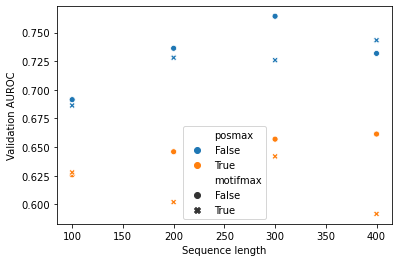

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot("seqlen", "val_auc", hue = "posmax", style="motifmax", data = res_df)
plt.xlabel("Sequence length")
plt.ylabel("Validation AUROC")

In [86]:
phys_net = biophysnn.PhysNet(specific_pwms, max_over_positions = False, max_over_motifs = False, seq_len = seq_len)
phys_net.load_state_dict(torch.load("checkpoints/posmax0_motifmax0_len300.pt"))
for k,v in phys_net.named_parameters(): 
    print(k,v)

motif_scale_unc Parameter containing:
tensor([-0.9757, -2.0196, -1.4592, -1.5440, -0.3201], requires_grad=True)
motif_offset Parameter containing:
tensor([-6.1055, -8.8217, -7.3100, -5.6302, -5.3519], requires_grad=True)
scale_unc Parameter containing:
tensor(2.2920, requires_grad=True)
offset Parameter containing:
tensor(-6.9013, requires_grad=True)


In [100]:
phys_net.scale

tensor(2.3883)

In [88]:
phys_net.motif_scale

tensor([0.3199, 0.1246, 0.2090, 0.1935, 0.5459])

## Fine tune PWMs

In [103]:
scaled_pwm = specific_pwms * phys_net.motif_scale[:,None,None]
fine_net = biophysnn.FinePhysNet(scaled_pwm, 
                                 motif_offset = phys_net.motif_offset.data,
                                 scale_unc = phys_net.scale_unc.data, 
                                 offset = phys_net.offset.data, 
                                 seq_len = phys_net.seq_len)
fine_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(fine_net, 
                                                       train_data, 
                                                       validation_data, 
                                                       genome, 
                                                       verbose = True, 
                                                       check_point_filename = "checkpoints/fine_net.pt",
                                                       lr = 0.1) # val auc 0.832

Epoch 1 took 16.61s. Train loss: 0.5686 acc: 0.7172 auc 0.782. Val loss: 0.6082 acc: 0.6552 auc 0.818. Patience left: 10
Epoch 2 took 16.51s. Train loss: 0.5525 acc: 0.7306 auc 0.797. Val loss: 0.5573 acc: 0.7142 auc 0.825. Patience left: 10
Epoch 3 took 16.36s. Train loss: 0.5481 acc: 0.7334 auc 0.801. Val loss: 0.5521 acc: 0.7206 auc 0.827. Patience left: 10
Epoch 4 took 16.39s. Train loss: 0.5431 acc: 0.7369 auc 0.805. Val loss: 0.5382 acc: 0.7372 auc 0.828. Patience left: 10
Epoch 5 took 16.51s. Train loss: 0.5382 acc: 0.7411 auc 0.810. Val loss: 0.5312 acc: 0.7451 auc 0.830. Patience left: 10
Epoch 6 took 16.32s. Train loss: 0.5349 acc: 0.7434 auc 0.812. Val loss: 0.5257 acc: 0.7481 auc 0.830. Patience left: 10
Epoch 7 took 16.50s. Train loss: 0.5338 acc: 0.7437 auc 0.813. Val loss: 0.5226 acc: 0.7515 auc 0.830. Patience left: 10
Epoch 8 took 16.37s. Train loss: 0.5339 acc: 0.7442 auc 0.813. Val loss: 0.5249 acc: 0.7473 auc 0.831. Patience left: 9
Epoch 9 took 16.36s. Train loss: 

In [120]:
torch.corrcoef(torch.stack([scaled_pwm.flatten(), fine_net.pwm.cpu().flatten()]))

tensor([[1.0000, 0.4959],
        [0.4959, 1.0000]])

In [139]:
scaled_pwm = specific_pwms * phys_net.motif_scale[:,None,None]
fine_net = biophysnn.FinePhysNet(scaled_pwm, 
                                 motif_offset = phys_net.motif_offset.data,
                                 scale_unc = phys_net.scale_unc.data, 
                                 offset = phys_net.offset.data, 
                                 seq_len = phys_net.seq_len)
fine_net.load_state_dict(torch.load("checkpoints/fine_net.pt"))

<All keys matched successfully>

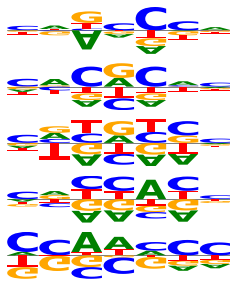

In [152]:
import logomaker

def plot_motifs(pwms):
    pwms_norm = pwms - pwms.mean(1,keepdims=True) 
    nMotif = pwms_norm.shape[0]
    plt.figure(figsize=(4,nMotif))
    for i in range(nMotif): 
        ax = plt.subplot(nMotif,1,i+1)
        plt.axis('off')
        pwm_df = pd.DataFrame(data = pwms_norm[i,:,:].t().numpy(), columns=("A","C","G","T"))
        crp_logo = logomaker.Logo(pwm_df, ax=ax) 

plot_motifs(specific_pwms)

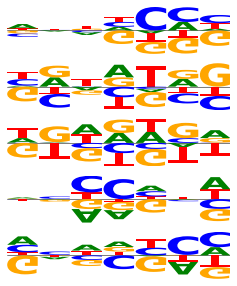

In [153]:
plot_motifs(fine_net.pwm)

## Fully de novo

In [155]:
de_novo_net = biophysnn.FinePhysNet(torch.randn_like(specific_pwms) * 0.3, 
                                 seq_len = 300)
de_novo_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo_net, 
                                                       train_data, 
                                                       validation_data, 
                                                       genome, 
                                                       verbose = True, 
                                                       check_point_filename = "checkpoints/denovo.pt",
                                                       lr = 0.1) # val auc 0.763

Epoch 1 took 13.06s. Train loss: 0.9107 acc: 0.6450 auc 0.674. Val loss: 0.5730 acc: 0.7182 auc 0.788. Patience left: 10
Epoch 2 took 12.89s. Train loss: 0.5761 acc: 0.7122 auc 0.775. Val loss: 0.6063 acc: 0.6697 auc 0.800. Patience left: 9
Epoch 3 took 13.05s. Train loss: 0.5721 acc: 0.7151 auc 0.779. Val loss: 0.6073 acc: 0.6686 auc 0.803. Patience left: 8
Epoch 4 took 13.17s. Train loss: 0.5671 acc: 0.7193 auc 0.785. Val loss: 0.6013 acc: 0.6762 auc 0.807. Patience left: 7
Epoch 5 took 13.05s. Train loss: 0.5648 acc: 0.7208 auc 0.786. Val loss: 0.5970 acc: 0.6788 auc 0.809. Patience left: 6
Epoch 6 took 13.24s. Train loss: 0.5599 acc: 0.7247 auc 0.791. Val loss: 0.5913 acc: 0.6839 auc 0.812. Patience left: 5
Epoch 7 took 13.08s. Train loss: 0.5566 acc: 0.7269 auc 0.794. Val loss: 0.5738 acc: 0.7048 auc 0.813. Patience left: 4
Epoch 8 took 12.87s. Train loss: 0.5547 acc: 0.7278 auc 0.795. Val loss: 0.5614 acc: 0.7163 auc 0.814. Patience left: 10
Epoch 9 took 13.08s. Train loss: 0.552

KeyboardInterrupt: 

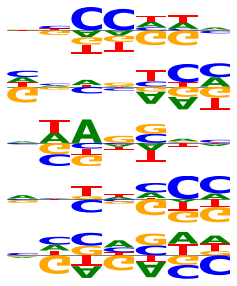

In [157]:
de_novo_net = biophysnn.FinePhysNet(torch.randn_like(specific_pwms), 
                                 seq_len = 300)
de_novo_net.load_state_dict(torch.load("checkpoints/denovo.pt"))
plot_motifs(de_novo_net.pwm.detach().cpu())

In [158]:
de_novo_net.motif_offset

Parameter containing:
tensor([-2.5201, -2.8762, -3.4786, -3.3278, -2.8230], requires_grad=True)

In [147]:
de_novo_net.offset

Parameter containing:
tensor(-2.6478, requires_grad=True)

In [ ]:
de_novo_net.scale

## De novo one motif

In [159]:
de_novo1_net = biophysnn.FinePhysNet(torch.randn((1,4,7)) * 0.1, 
                                 seq_len = 300)
de_novo1_net, train_accs, val_accs, train_aucs, val_aucs = biophysnn.train_model(de_novo1_net, 
                                                       train_data, 
                                                       validation_data, 
                                                       genome, 
                                                       verbose = True, 
                                                       check_point_filename = "checkpoints/denovo_1motif.pt",
                                                       lr = 0.1) # val auc 0.763

Epoch 1 took 12.73s. Train loss: 0.7751 acc: 0.6453 auc 0.679. Val loss: 0.6032 acc: 0.6820 auc 0.777. Patience left: 10
Epoch 2 took 13.01s. Train loss: 0.5804 acc: 0.7098 auc 0.772. Val loss: 0.5559 acc: 0.7310 auc 0.799. Patience left: 10
Epoch 3 took 12.86s. Train loss: 0.5680 acc: 0.7194 auc 0.784. Val loss: 0.6005 acc: 0.6802 auc 0.804. Patience left: 9
Epoch 4 took 12.84s. Train loss: 0.5662 acc: 0.7198 auc 0.786. Val loss: 0.6045 acc: 0.6773 auc 0.806. Patience left: 8
Epoch 5 took 13.06s. Train loss: 0.5669 acc: 0.7190 auc 0.785. Val loss: 0.6067 acc: 0.6746 auc 0.806. Patience left: 7
Epoch 6 took 12.66s. Train loss: 0.5673 acc: 0.7183 auc 0.784. Val loss: 0.6071 acc: 0.6743 auc 0.806. Patience left: 6
Epoch 7 took 12.96s. Train loss: 0.5674 acc: 0.7179 auc 0.784. Val loss: 0.6070 acc: 0.6745 auc 0.806. Patience left: 5
Epoch 8 took 12.69s. Train loss: 0.5675 acc: 0.7178 auc 0.784. Val loss: 0.6070 acc: 0.6744 auc 0.806. Patience left: 4
Epoch 9 took 12.69s. Train loss: 0.567

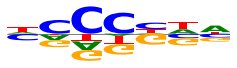

In [174]:
de_novo1_net = biophysnn.FinePhysNet(torch.randn((1,4,7)) * 0.1, 
                                 seq_len = 300)
de_novo1_net.load_state_dict(torch.load("checkpoints/denovo_1motif.pt"))
plot_motifs(de_novo1_net.pwm.detach().cpu())

In [173]:
de_novo1_net.motif_offset.data, de_novo1_net.scale.data, de_novo1_net.offset.data

(tensor([-0.6707]), tensor(2.4695), tensor(-5.5516))

## Test flipped CNN

In [ ]:
test_acc_flipped = {}
seq_lens = {}
test_acc_regular = {}
for num_filters in range(1,17): 
    print(num_filters, end = " ")
    flipped_cnn = CNN_1d(use_flipping=True, nchannels = [4, num_filters], n_hidden = 16, filter_widths = [10])
    seq_lens[num_filters] = flipped_cnn.seq_len
    flipped_cnn, train_accs, val_accs = train_model(flipped_cnn, train_data, validation_data, verbose = False)
    test_dataset = BedPeaksDataset(test_data, genome, flipped_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_flipped[num_filters] = run_one_epoch(test_dataloader, flipped_cnn, None)
    #test_acc_flipped # .662, .666 for FlippedConv, .66 without flipping, .665 with NewFlipping

    regular_cnn = CNN_1d(use_flipping=False,  nchannels = [4, num_filters], n_hidden = 16, filter_widths = [11])
    regular_cnn, train_accs, val_accs = train_model(regular_cnn, train_data, validation_data, verbose = False)
    test_dataset = BedPeaksDataset(test_data, genome, regular_cnn.seq_len)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
    test_loss, test_acc_regular[num_filters] = run_one_epoch(test_dataloader, regular_cnn, None)

plt.plot(list(seq_lens.values()))

In [ ]:
test_acc_flipped_values = np.array(list(test_acc_flipped.values()))
print("%.3f +/- %.3f" % (test_acc_flipped_values.mean(), test_acc_flipped_values.std()))

In [ ]:
for i in range(10): 
    print(i, end = " ")

test_acc_regular_values = np.array(list(test_acc_regular.values()))
print("%.3f +/- %.3f" % (test_acc_regular_values.mean(), test_acc_regular_values.std()))

In [ ]:
test_acc_regular_values

Across 10 replicates: biophysical 0.668 +/- 0.003, regular 0.665 +/- 0.007 (so probably not statistically signicant?) 